<h2> NLP Classification - Toxic comment detection system </h2>

In this notebook we'll study how to make a Toxic comment detection system based on NLP classification using different methods such as Naive Baye, LSTM and transformers (Bert in particular).

<h3> Introduction - Quick Data exploration </h3>

In [1]:
import os
import re
import nltk
import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split

LIST_LABEL = ["toxic", "obscene", "threat", "insult", "identity_hate"]
data = pd.read_csv(os.path.join("toxicComments.csv"))
data['normal'] = (data.iloc[:, 2:].max(axis=1) == 0)
data['label'] = (data.iloc[:, 2:] == 1).idxmax(1)
data.drop(columns=['normal', 'severe_toxic'], inplace=True)
data.head()

,id,comment_text,toxic,obscene,threat,insult,identity_hate,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,normal
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,normal
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,normal
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,normal
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,normal


In [2]:
print('Number of NaN values:\n' + str(data.isnull().sum()))

Number of NaN values:
id               0
comment_text     0
toxic            0
obscene          0
threat           0
insult           0
identity_hate    0
label            0
dtype: int64


In [3]:
print(data['label'].value_counts(normalize=True)*100)

normal           89.832112
toxic             9.584448
obscene           0.327754
insult            0.206178
identity_hate     0.033841
threat            0.015667
Name: label, dtype: float64


We have 9.58% toxic comment, 0.32% Obscene, 0.016% Threat, 0.21% Insult and 0.034% Identity hate.

<h3> Part I - Naive Baye Classification (One vs Rest): </h3>

train len: 135635
test len: 23936

Model 1 label: toxic
Recall: 0.9742168006653729
Specificity: 0.7031386224934612

Model 2 label: obscene
Recall: 0.9798888594866367
Specificity: 0.7678288431061807

Model 3 label: threat
Recall: 0.988266845457593
Specificity: 0.5416666666666666

Model 4 label: insult
Recall: 0.9734878412782021
Specificity: 0.7322357019064125

Model 5 label: identity_hate
Recall: 0.9819462605981356
Specificity: 0.6157205240174672

Final model :


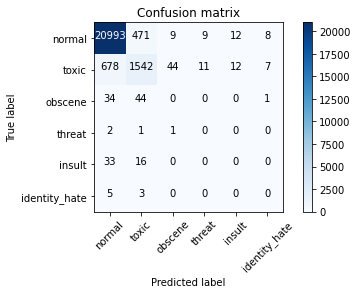

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def NB_text_processing(text):
    ''' Return cleaned text for Machine Learning '''
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    NEW_LINE = re.compile('\n')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(nltk.corpus.stopwords.words('english'))
    STEMMER = SnowballStemmer('english')

    text = text.lower()
    text = unidecode.unidecode(text)
    text = NEW_LINE.sub(' ',text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text = ' '.join([STEMMER.stem(word) for word in text.split() if word not in STOPWORDS])
    return text

def NB_preprocessing_OneVSR(data):
    ''' Return train and test set '''
    X = data['comment_text'].tolist()
    X = [NB_text_processing(txt) for txt in X]
    cv = CountVectorizer(max_features = 5000)
    X = cv.fit_transform(X).toarray()
    Y = data[LIST_LABEL+['label']]
    
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.15,train_size=0.85, stratify=data['label'].values)
    print('train len:', len(x_train))
    print('test len:', len(x_test))

    return x_train, x_test, y_train, y_test

def NB_Model_OneVSR(x_train, x_test, y_train, y_test, labelName):
    ''' Create a model based on Naive Bayes '''
    Y = y_train[labelName].tolist()
    Y2 = y_test[labelName].tolist()
    model = MultinomialNB()
    model.fit(x_train, Y)
    
    y_pred = model.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(Y2, y_pred).ravel()
    specificity = tp / (tp+fn)
    recall = tn / (tn+fp)
    print('Recall:', recall)
    print('Specificity:', specificity)
    return model

def NB_Train_OneVSR(x_train, x_test, y_train, y_test):
    tab_models = []; tab_proba = []
    for i in range(len(LIST_LABEL)):
        print('\nModel ' + str(i+1) + ' label: ' + LIST_LABEL[i])
        tab_models.append(NB_Model_OneVSR(x_train, x_test, y_train, y_test, LIST_LABEL[i]))
        tmp = []
        for proba in tab_models[i].predict_proba(x_test):
            tmp.append(proba[1])
        tab_proba.append(tmp)
    print('\nFinal model :')
    pred = []
    for i in range(len(x_test)):
        maxProba = 0; label = 'normal'
        for y in range(len(tab_proba)):
            if(maxProba < tab_proba[y][i]):
                maxProba = tab_proba[y][i]
                label = LIST_LABEL[y]
        if(maxProba < 0.5): label = 'normal'
        pred.append(label)
    
    cm = confusion_matrix(y_test['label'].tolist(), pred, labels=['normal']+LIST_LABEL)
    plot_confusion_matrix(cm, classes=['normal']+LIST_LABEL)
        
x_train, x_test, y_train, y_test = NB_preprocessing_OneVSR(data)
NB_Train_OneVSR(x_train, x_test, y_train, y_test)

The algorithm work only for normal and toxic comments with 96.54% and 74.24% accuracy respectively.

<h3> Part I (b) - Naive Baye Classification: </h3>

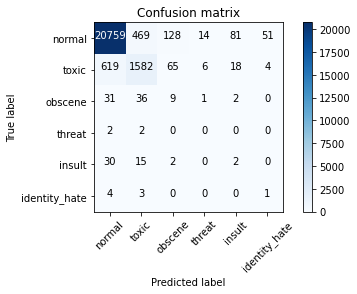

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

def NB_Model(x_train, x_test, y_train, y_test):
    ''' Create a model based on Naive Bayes '''
    classifier = MultinomialNB()
    classifier.fit(x_train, y_train)

    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, labels=['normal']+LIST_LABEL)
    plot_confusion_matrix(cm, classes=['normal']+LIST_LABEL)

NB_Model(x_train, x_test, y_train['label'].tolist(), y_test['label'].tolist())

del x_train; del x_test; del y_train; del y_test

Kind of the same accuracy as the other algorithm above.

<h3> Part II - LSTM Classification: </h3>

In [4]:
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def NB_text_processing(text):
    ''' Return cleaned text for Machine Learning '''
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    NEW_LINE = re.compile('\n')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(nltk.corpus.stopwords.words('english'))
    STEMMER = SnowballStemmer('english')

    text = text.lower()
    text = unidecode.unidecode(text)
    text = NEW_LINE.sub(' ',text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text = ' '.join([STEMMER.stem(word) for word in text.split() if word not in STOPWORDS])
    return text

indexes = data[data['label'] == 'normal'].index
indexes = indexes[10000::] #keep the first 10000 normal data
data2 = data.drop(indexes)
data2 = data2.reset_index()
data2.drop(columns=('index'), inplace=True)

X = data2['comment_text'].apply(lambda x: NB_text_processing(x))
Y = data2['label'].tolist()
del data2
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1))
print(X)
print(Y.shape)

c=[]
for i in range(len(X)):
    m=len(X[i].split())
    c.append(m)
print('Maximum length of a sentence is : ',max(c))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen = max(c))
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.15,train_size=0.85)

0        explan edit made usernam hardcor metallica fan...
1        daww match background colour im seem stuck tha...
2        hey man im realli tri edit war guy constant re...
3        cant make real suggest improv wonder section s...
4                          sir hero chanc rememb page that
                               ...                        
26220    previous convers fuck shit eat liber make ladi...
26221                                 mischievi pubic hair
26222    absurd edit absurd edit great white shark tota...
26223    hey listen dont ever delet edit ever im annoy ...
26224    im go keep post stuff u delet fuck site close ...
Name: comment_text, Length: 26225, dtype: object
(26225, 6)
Maximum length of a sentence is :  1250
Vocabulary Size : 50766


In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

''' You have to download this file: http://nlp.stanford.edu/data/glove.6B.zip
    his weight is 1GO !'''

EMBEDDING_DIM = 300
BATCH_SIZE = 32

embeddings_index = {}

f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(vocab_size
    , EMBEDDING_DIM
    , weights=[embedding_matrix]
    , input_length=max(c)
    , trainable=False)

Found 400000 word vectors.


In [6]:
import tensorflow as tf

def MakeModel():
    sequence_input = Input(shape=(max(c),), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(len(LIST_LABEL)+1, activation='softmax')(x)
    model = Model(sequence_input, outputs)
    print(model.summary())
    return model

model = MakeModel()
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1250)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1250, 300)         15229800  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1250, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1246, 64)          96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [7]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=1, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau, model_checkpoint_callback])

697/697 [==============================] - 14917s 21s/step - loss: 0.5391 - accuracy: 0.8068 - val_loss: 0.4906 - val_accuracy: 0.8348


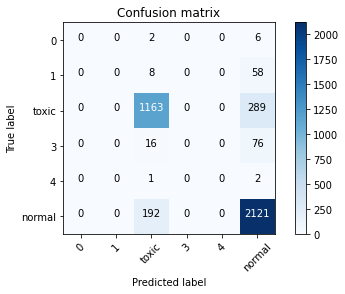

In [29]:
y_tmp = model.predict(x_test)
y_pred = []
y_test2 = []
correct_pred = 0
for i in range(len(y_tmp)):
    if(np.argmax(y_tmp[i]) == 5):
        y_pred.append('normal')
    elif(np.argmax(y_tmp[i]) == 2):
        y_pred.append('toxic')
    else:
        y_pred.append(str(np.argmax(y_tmp[i])))
for i in range(len(y_test)):
    if(np.argmax(y_test[i]) == 5):
        y_test2.append('normal')
    elif(np.argmax(y_test[i]) == 2):
        y_test2.append('toxic')
    else:
        y_test2.append(str(np.argmax(y_test[i])))
    if(y_test2[i] == y_pred[i]): correct_pred = correct_pred+1
cm = confusion_matrix(y_test2, y_pred, labels=['0', '1', 'toxic', '3', '4', 'normal'])
plot_confusion_matrix(cm, classes=['0', '1', 'toxic', '3', '4', 'normal'])

It classifies well only for normal and toxic data with an accuracy of 83.48% for normal data.

<h3> Part III - Bert Classification: </h3>

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math

def Bert_preprocess_text(text, device, tokenizer):
    ''' Encode text '''
    parts = []
    text_len = len(text.split(' '))
    delta = 300
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

def Bert_train_epoch(model, x_train, y_train, loss_fn, optimizer, device, tokenizer):
    ''' Train Bert model for one epoch '''
    print_every = 300; total_loss = 0
    all_losses = []; CUDA_LAUNCH_BLOCKING=1
    model.train()
    correct_predictions = 0; minLoss = math.inf
    for idx in range(len(x_train)):
        text_parts = Bert_preprocess_text(x_train[idx], device, tokenizer)
        label = torch.tensor([y_train[idx]]).to(device)
        overall_output = torch.zeros((1, len(LIST_LABEL)+1)).float().to(device)
        for part in text_parts:
            if len(part) > 0:
                try:
                    input = part.reshape(-1)[:512].reshape(1, -1)
                    overall_output += model(input, labels=label)[1].float().to(device)
                except Exception as e:
                    print(str(e))
        overall_output = F.softmax(overall_output[0], dim=-1)
        overall_output = overall_output[None, :]
        correct_predictions += (np.argmax(overall_output.cpu().detach().numpy()) == label).item()
        loss = loss_fn(overall_output, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if idx % print_every == 0 and idx > 0:
            average_loss = total_loss / print_every
            if(minLoss > average_loss):
                minLoss = average_loss
                torch.save(model.state_dict(), 'model.pt') #Save best loss
            print("{}/{}. Average loss: {} | Accuracy: {}%".format(idx, len(x_train), average_loss, (correct_predictions/idx)*100))
            all_losses.append(average_loss)
            total_loss = 0
    model.load_state_dict(torch.load('model.pt'))
    print("Best loss taken: ", minLoss)
            
def Bert_eval_model(model, x_val, y_val, loss_fn, device, tokenizer):
    ''' Evaluate Bert model on validation data '''
    total_loss = 0; all_losses = []
    model.eval()
    correct_predictions = 0
    with torch.no_grad():
        for idx in range(len(x_val)):
            text_parts = Bert_preprocess_text(x_val[idx], device, tokenizer)
            label = torch.tensor([y_val[idx]]).long().to(device)
            overall_output = torch.zeros((1, len(LIST_LABEL)+1)).float().to(device)
            for part in text_parts:
                if len(part) > 0:
                    try:
                        input = part.reshape(-1)[:512].reshape(1, -1)
                        overall_output += model(input, labels=label)[1].float().to(device)
                    except Exception as e:
                        print(str(e))
            overall_output = F.softmax(overall_output[0], dim=-1)
            overall_output = overall_output[None, :]
            correct_predictions += (np.argmax(overall_output.cpu().detach().numpy()) == label).item()
            loss = loss_fn(overall_output, label)
            total_loss += loss.item()
        average_loss = total_loss / len(x_val)
        print("\nAverage val loss: {} | Val accuracy: {}%".format(average_loss, (correct_predictions/len(x_val))*100))
        all_losses.append(average_loss)
        total_loss = 0
    

def Bert_train_model(X, Y):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    x, x_test, y, y_test = train_test_split(X,Y,test_size=0.05,train_size=0.95)
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.15,train_size=0.85)
    
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    model.classifier = nn.Sequential(
        nn.Linear(model.config.hidden_size, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, len(LIST_LABEL)+1),
        nn.Softmax(dim=1))
    for name, param in model.named_parameters(): #Freeze Bert
        if 'classifier' not in name:
            param.requires_grad = False
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.AdamW(model.classifier.parameters(), lr=3e-5)
    
    EPOCHS = 1
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        Bert_train_epoch(model, x_train, y_train, criterion, optimizer, device, tokenizer)
        Bert_eval_model(model, x_val, y_val, criterion, device, tokenizer)
        
indexes = data[data['label'] == 'normal'].index
indexes = indexes[10000::] #keep the first 10000 normal data
data2 = data.drop(indexes)
data2 = data2.reset_index()
data2.drop(columns=('index'), inplace=True)

X = data2['comment_text'].tolist()
Y = data2['label'].tolist()
del data2
le = LabelEncoder()
Y = le.fit_transform(Y)
Bert_train_model(X, Y)


Epoch 1/1
----------


C:\Users\Seren\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


300/21176. Average loss: 1.7590651404857636 | Accuracy: 49.666666666666664%
600/21176. Average loss: 1.6921317303180694 | Accuracy: 56.333333333333336%
900/21176. Average loss: 1.6966812320550282 | Accuracy: 57.333333333333336%
1200/21176. Average loss: 1.697524412870407 | Accuracy: 57.666666666666664%
1500/21176. Average loss: 1.6984654041131337 | Accuracy: 57.93333333333334%
1800/21176. Average loss: 1.7047674334049225 | Accuracy: 57.77777777777777%
2100/21176. Average loss: 1.7047665091355642 | Accuracy: 57.333333333333336%
2400/21176. Average loss: 1.6961723522345225 | Accuracy: 57.791666666666664%
2700/21176. Average loss: 1.7017818597952525 | Accuracy: 57.81481481481482%
3000/21176. Average loss: 1.7153957657019296 | Accuracy: 57.3%
3300/21176. Average loss: 1.6926135722796123 | Accuracy: 57.54545454545455%
3600/21176. Average loss: 1.6989095175266267 | Accuracy: 57.611111111111114%
3900/21176. Average loss: 1.7076865164438884 | Accuracy: 57.43589743589743%
4200/21176. Average lo

Considering we took 10000 normal data and the rest (50% of the data) is toxic, obscene, threat, insult and identity hate we can say that this is pretty bad.